In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pickle
import torchvision
from torchvision import datasets, models, transforms, utils


In [3]:
def read_from_pickle(path):
    output = None
    with open(path, 'rb') as file:
        try:
            while True:
                output =  pickle.load(file)
        except EOFError:
            pass
    return output



In [4]:
CAM_path = '/home/ubuntu/deepsolar/src/baseline_CAM_list.pickle'
CAM_list = read_from_pickle(CAM_path)

In [5]:
def extract_pos_prompts_from_cam(cam, img, prompt_threshold, n):
    # cam_image = cv2.cvtColor(uint_cam, cv2.COLOR_GRAY2BGR)

    prompt_ix = np.argwhere(cam > prompt_threshold)
    if prompt_ix.shape[0] <= 0:
        return prompt_ix, prompt_ix
    sample_ix = np.random.randint(0, prompt_ix.shape[0], size=n)

    prompt_ix = prompt_ix[sample_ix]

    cam_to_img_x = img.shape[0] / cam.shape[0]
    cam_to_img_y = img.shape[1] / cam.shape[1]

    prompt_ix_scaled = np.zeros_like(prompt_ix)
    prompt_ix_scaled[:, 0] = prompt_ix[:, 0] * cam_to_img_x + cam_to_img_x / 2
    prompt_ix_scaled[:, 1] = prompt_ix[:, 1] * cam_to_img_y + cam_to_img_y / 2

    prompt_ix[:, [1, 0]] = prompt_ix[:,[0,1]]
    prompt_ix_scaled[:, [1, 0]] = prompt_ix_scaled[:,[0,1]]

    return prompt_ix, prompt_ix_scaled


def extract_neg_prompts_from_cam(cam, img, prompt_threshold, n):
    # cam_image = cv2.cvtColor(uint_cam, cv2.COLOR_GRAY2BGR)

    prompt_ix = np.argwhere(cam < prompt_threshold)
    sample_ix = np.random.randint(0, prompt_ix.shape[0], size=n)

    prompt_ix = prompt_ix[sample_ix]
    cam_to_img_x = img.shape[0] / cam.shape[0]
    cam_to_img_y = img.shape[1] / cam.shape[1]

    prompt_ix_scaled = np.zeros_like(prompt_ix)
    prompt_ix_scaled[:, 0] = prompt_ix[:, 0] * cam_to_img_x + cam_to_img_x / 2
    prompt_ix_scaled[:, 1] = prompt_ix[:, 1] * cam_to_img_y + cam_to_img_y / 2

    prompt_ix[:, [1, 0]] = prompt_ix[:,[0,1]]
    prompt_ix_scaled[:, [1, 0]] = prompt_ix_scaled[:,[0,1]]

    return prompt_ix, prompt_ix_scaled


In [6]:
POS_THRESHOLD = 0.5
NEG_THRESHOLD = 0.1
N_POS_PROMPTS = 5
N_NEG_PROMPTS = 5

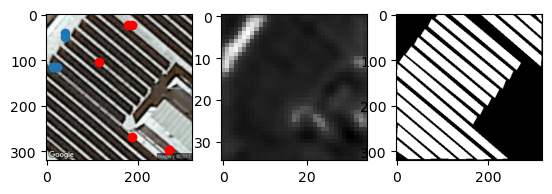

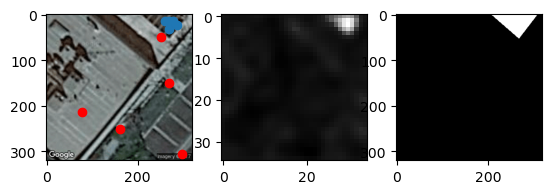

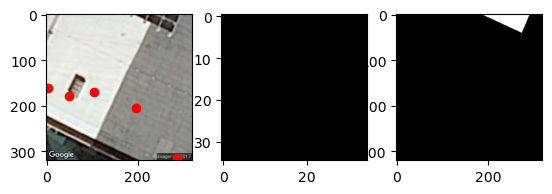

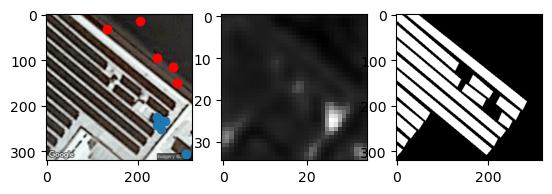

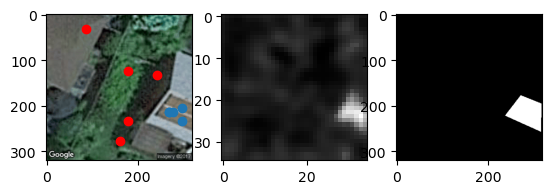

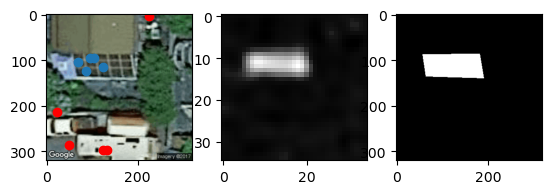

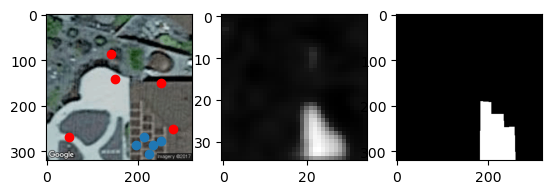

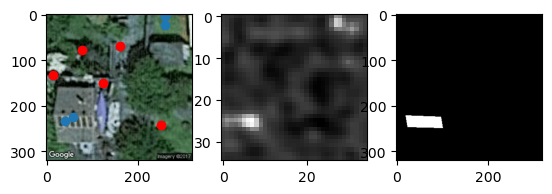

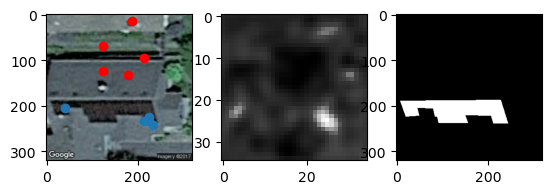

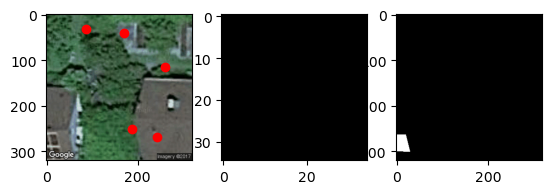

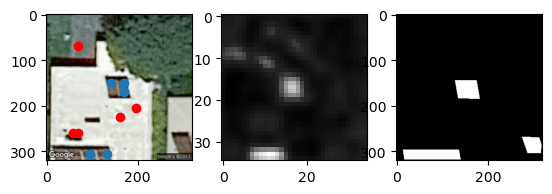

In [7]:
import os 
# Sample prompt generation from CAM 
num_to_display = 10
count = 0
for idx, (cam, path) in enumerate(CAM_list): 
    class_label = path.split('/')[-2]
    cam_rescaled = (cam - cam.min())/(cam.max() - cam.min() + 1e-5)
    if class_label == '1':
        count += 1
        img = cv2.imread(path, flags=cv2.IMREAD_COLOR)
        img_path = os.path.splitext(path)
        true_seg_path = img_path[0] + '_true_seg' + img_path[1]
        true_seg = cv2.imread(true_seg_path, flags=cv2.IMREAD_GRAYSCALE)

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f, axes = plt.subplots(1, 3)
        axes[0].imshow(img)
        axes[0].axis('on')

        axes[1].imshow(cam_rescaled, cmap=plt.cm.gray)
        axes[1].axis('on')

        axes[2].imshow(true_seg, cmap=plt.cm.gray)
        axes[2].axis('on')

        # TODO extract negative prompts also
        pos_prompts, scaled_pos_prompts = extract_pos_prompts_from_cam(cam_rescaled, img, POS_THRESHOLD, N_POS_PROMPTS)
        neg_prompts, scaled_neg_prompts = extract_neg_prompts_from_cam(cam_rescaled, img, NEG_THRESHOLD, N_NEG_PROMPTS)
        axes[0].scatter(scaled_pos_prompts[:,0], scaled_pos_prompts[:,1])
        axes[0].scatter(scaled_neg_prompts[:,0], scaled_neg_prompts[:,1], color='r')
        plt.show()

        if count > num_to_display:
            break

In [8]:
# Initialize SAM model. 
# See source code from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
import sys
sys.path.append("..")
import segment_anything
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/ubuntu/deepsolar/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [11]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()


In [12]:
POS_THRESHOLD = 0.5
NEG_THRESHOLD = 0.1
N_POS_PROMPTS = 3
N_NEG_PROMPTS = 3

/tmp/ipykernel_1706/3721386657.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_new.cpp:230.)
  'point_coords': torch.tensor([combined_prompts_scaled]).to(sam.device),


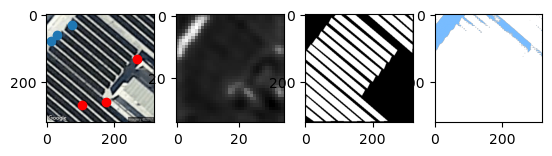

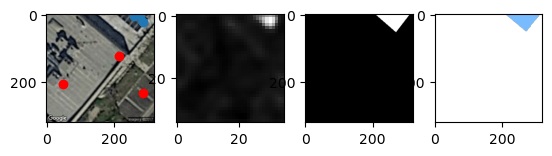

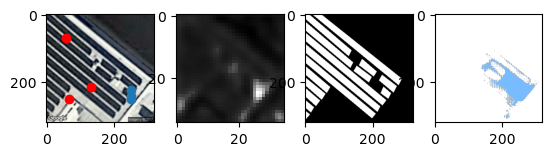

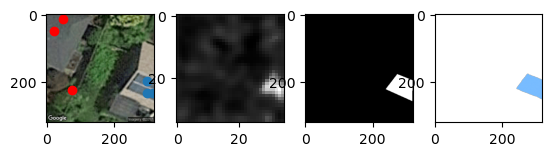

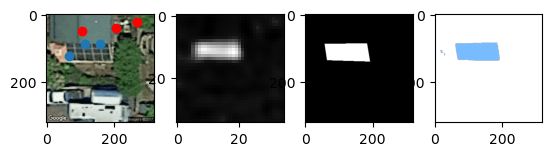

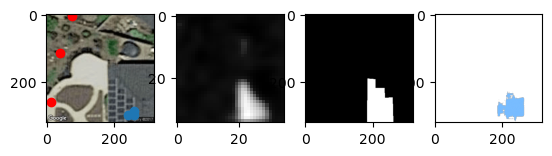

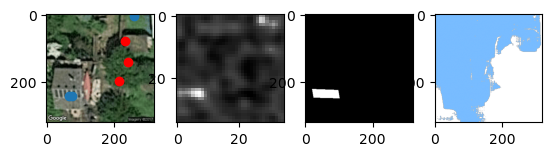

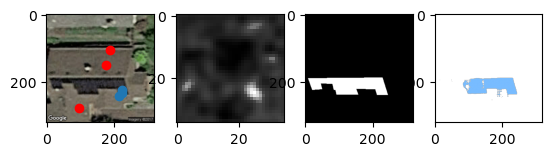

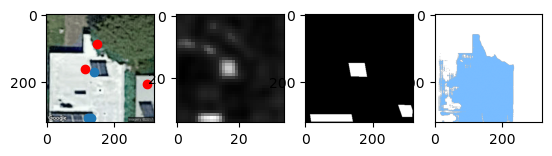

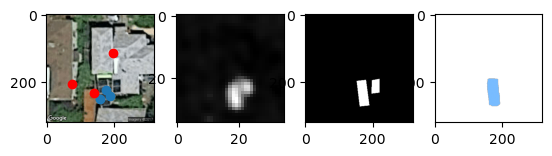

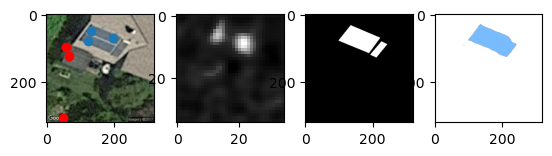

In [13]:

resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

num_to_display=10

count = 0
for idx, (cam, path) in enumerate(CAM_list): 
    class_label = path.split('/')[-2]
    cam_rescaled = (cam - cam.min())/(cam.max() - cam.min() + 1e-5)
    if class_label == '1':
        img = cv2.imread(path, flags=cv2.IMREAD_COLOR)
        img_path = os.path.splitext(path)
        true_seg_path = img_path[0] + '_true_seg' + img_path[1]
        true_seg = cv2.imread(true_seg_path, flags=cv2.IMREAD_GRAYSCALE)

        # TODO extract negative prompts also
        pos_prompts, scaled_pos_prompts = extract_pos_prompts_from_cam(cam_rescaled, img, POS_THRESHOLD, N_POS_PROMPTS)
        neg_prompts, scaled_neg_prompts = extract_neg_prompts_from_cam(cam_rescaled, img, NEG_THRESHOLD, N_NEG_PROMPTS)
        if pos_prompts.shape[0] < 1:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        prepared_image = prepare_image(img, resize_transform, sam)
        x_scale = prepared_image.shape[1] / img.shape[0]
        y_scale = prepared_image.shape[2] / img.shape[1]

        combined_prompts = np.concatenate((scaled_pos_prompts, scaled_neg_prompts), axis=0)
        combined_prompts_scaled = np.copy(combined_prompts)
        combined_prompts_scaled[:,0] = (combined_prompts_scaled[:,0] * x_scale).astype(int)
        combined_prompts_scaled[:,1] = (combined_prompts_scaled[:,1] * y_scale).astype(int)
        combined_labels = np.concatenate((np.ones(N_POS_PROMPTS), np.zeros(N_NEG_PROMPTS)))

        batched_input = [{'image': prepared_image,
                          'point_coords': torch.tensor([combined_prompts_scaled]).to(sam.device),
                          'point_labels': torch.tensor([combined_labels]).to(sam.device),
                          'original_size': img.shape[:2]}]
        
        batched_output = sam(batched_input, multimask_output=False)


        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f, axes = plt.subplots(1, 4)
        axes[0].imshow(img)
        axes[0].axis('on')

        axes[1].imshow(cam_rescaled, cmap=plt.cm.gray)
        axes[1].axis('on')

        axes[2].imshow(true_seg, cmap=plt.cm.gray)
        axes[2].axis('on')

        axes[0].scatter(scaled_pos_prompts[:,0], scaled_pos_prompts[:,1])
        axes[0].scatter(scaled_neg_prompts[:,0], scaled_neg_prompts[:,1], color='r')
        # show_points(combined_prompts, combined_labels, axes[3], marker_size=375)

        mask = batched_output[0]['masks'][0]
        show_mask(mask.cpu().numpy(), axes[3])
        plt.show()

        count += 1

        if count > num_to_display:
            break

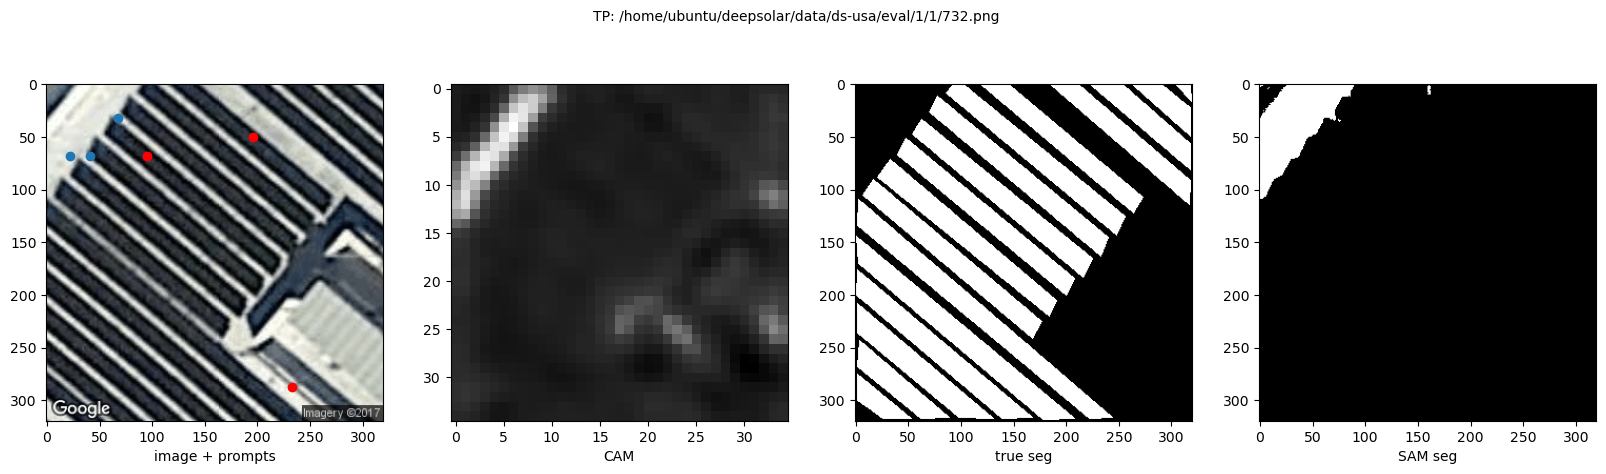

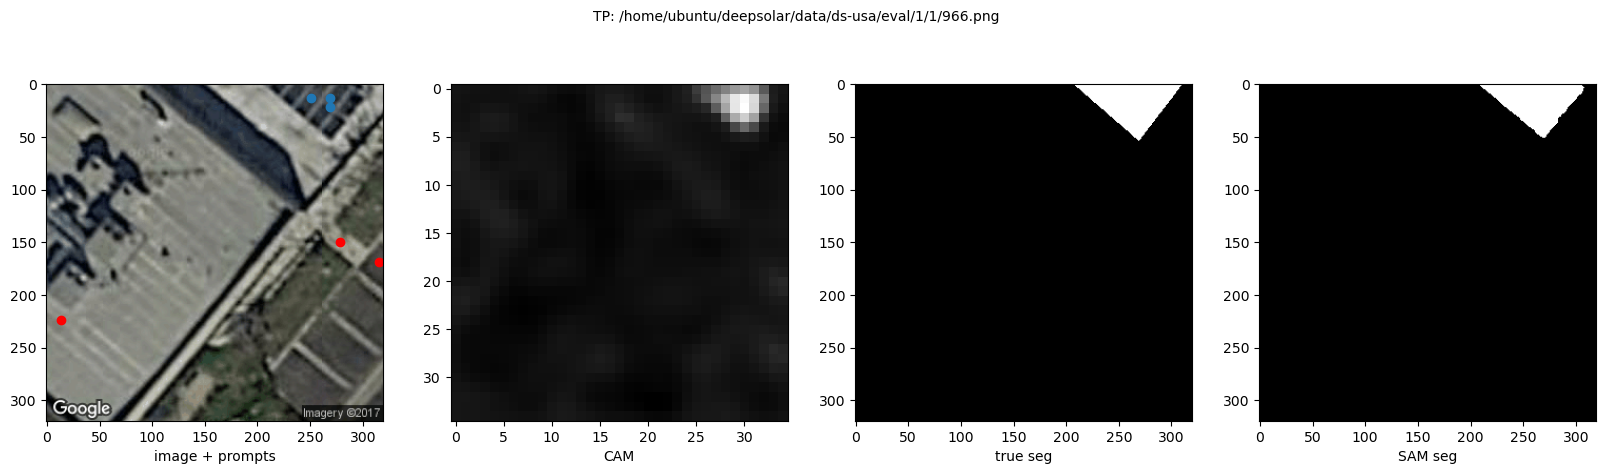

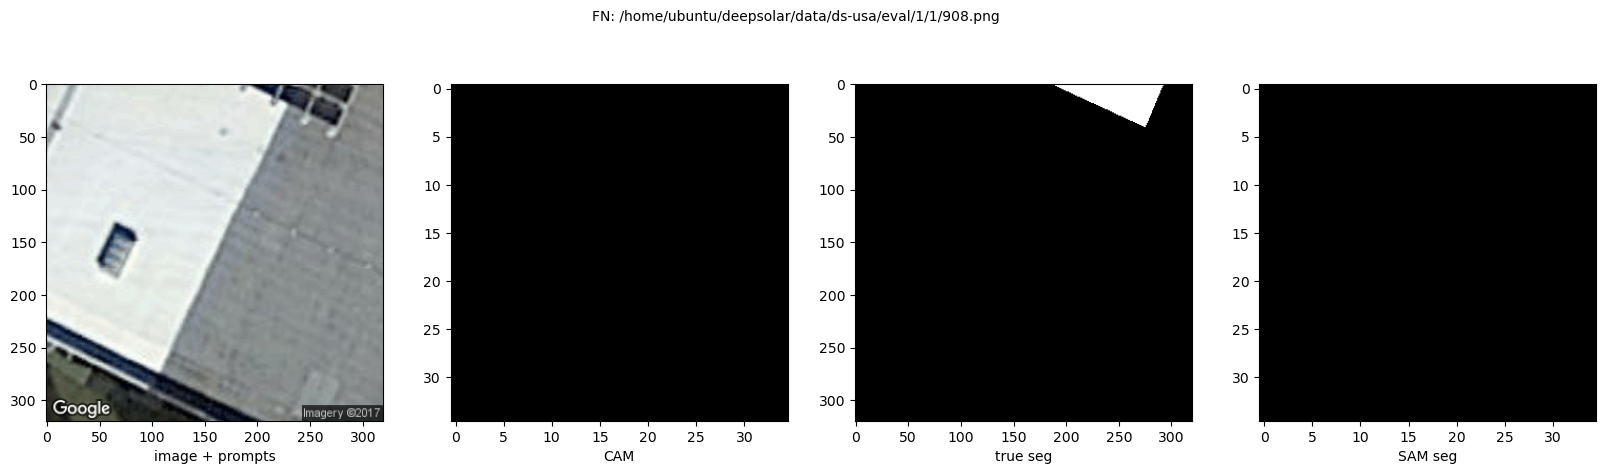

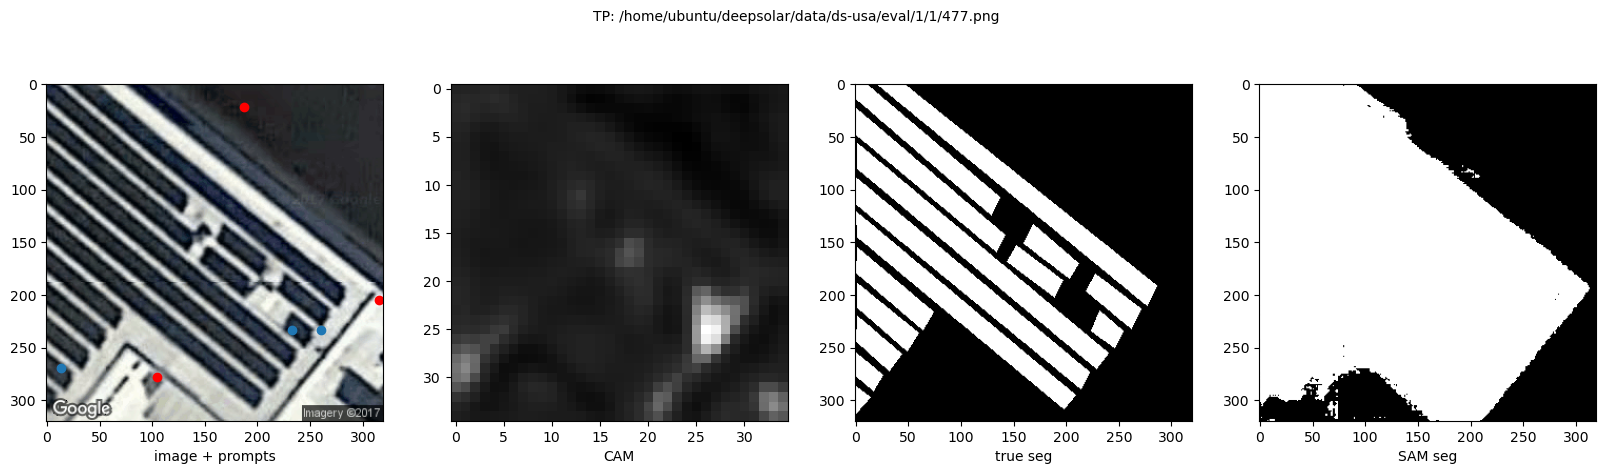

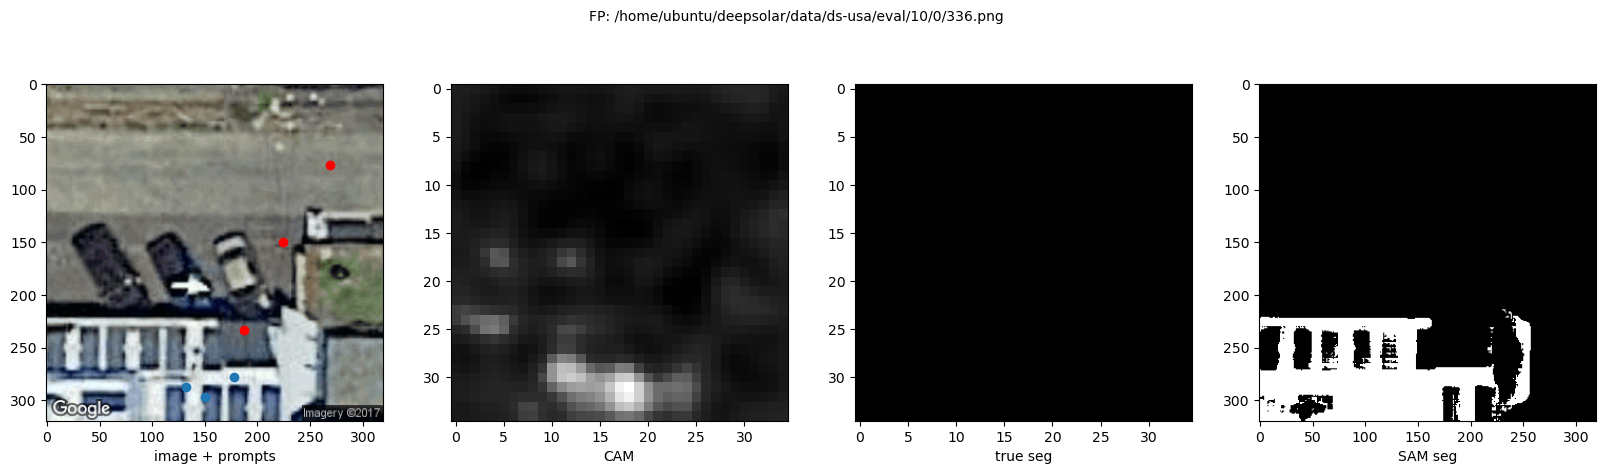

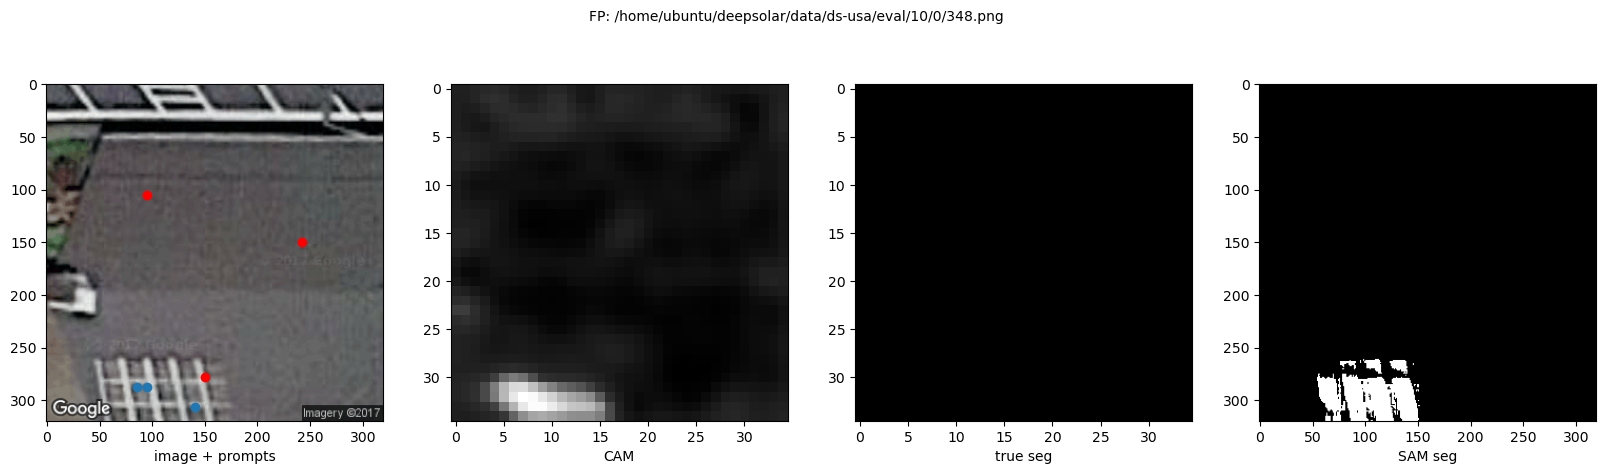

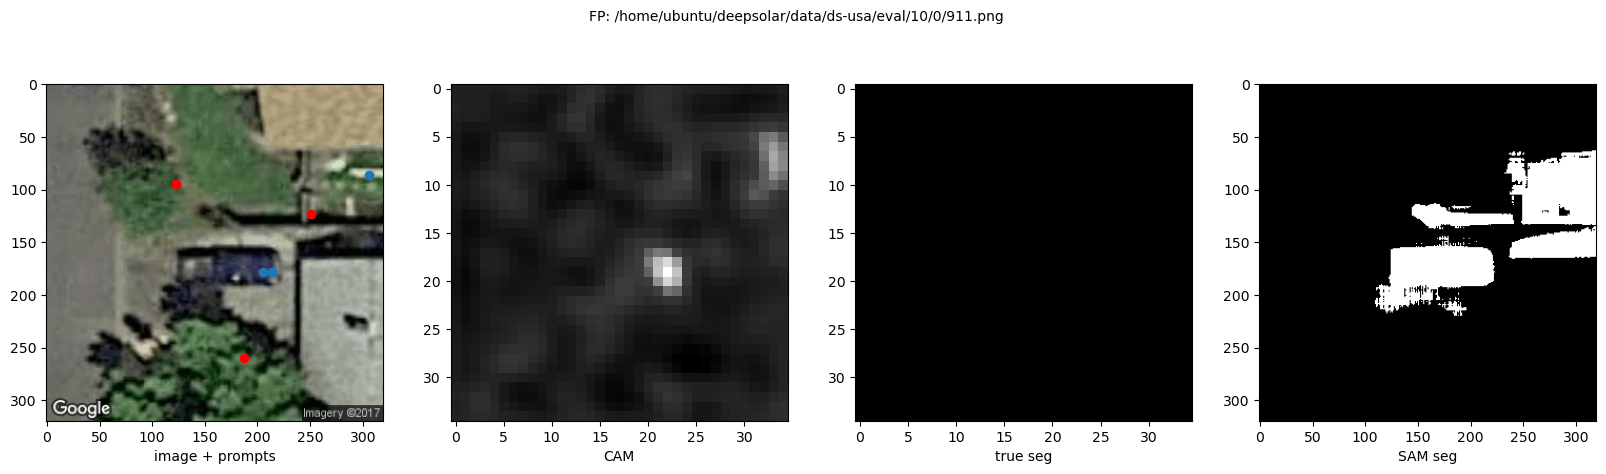

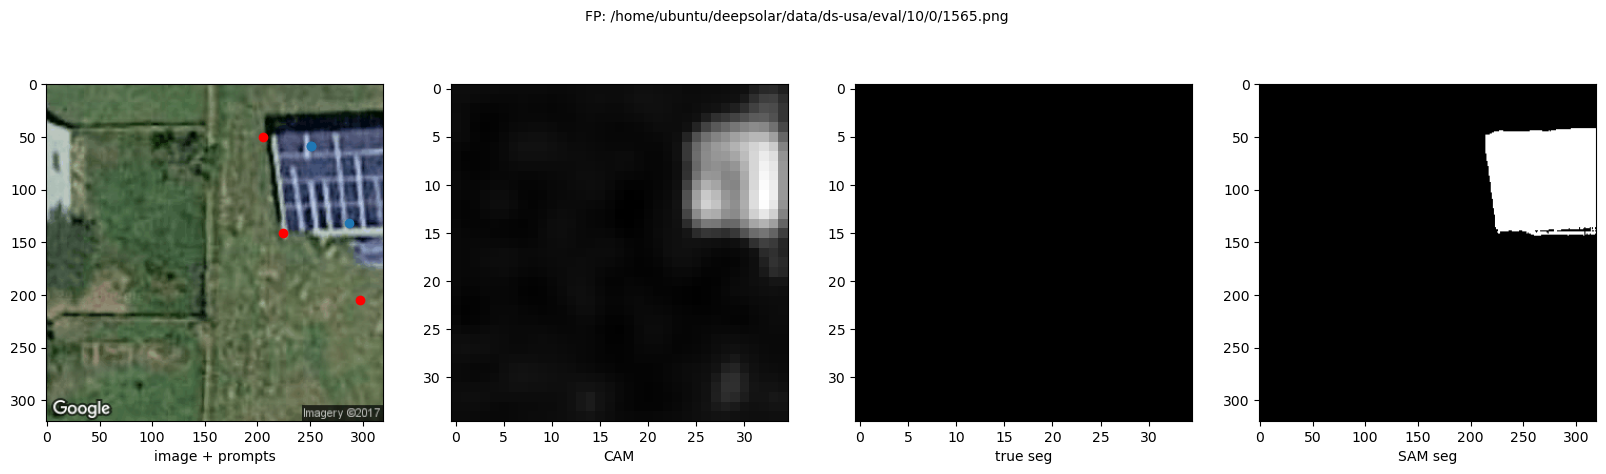

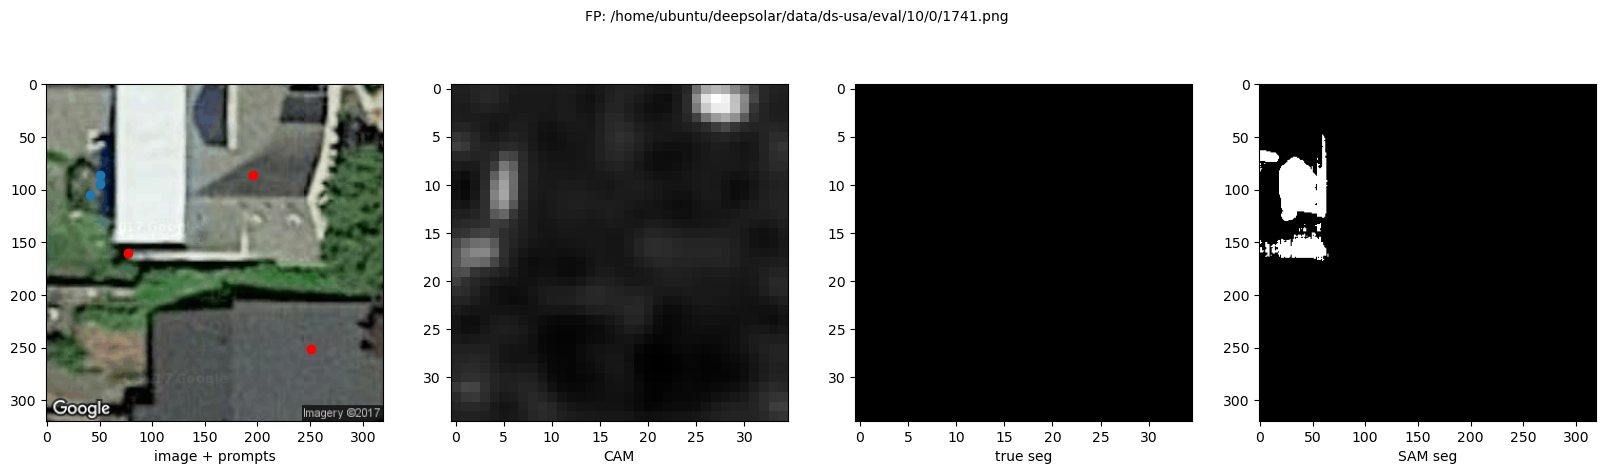

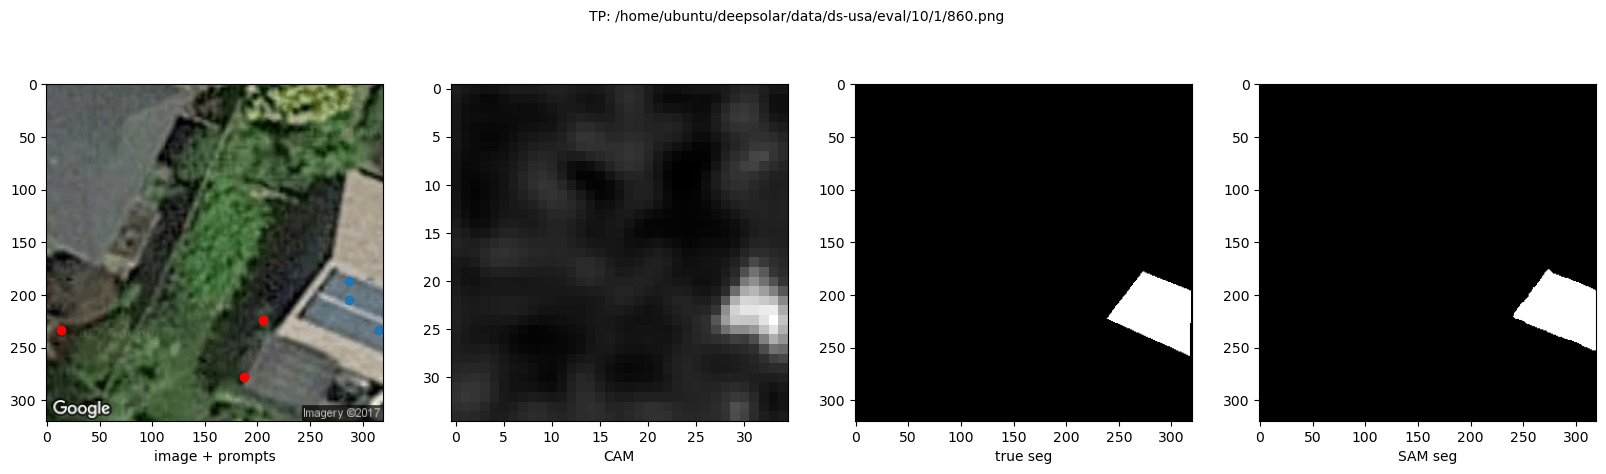

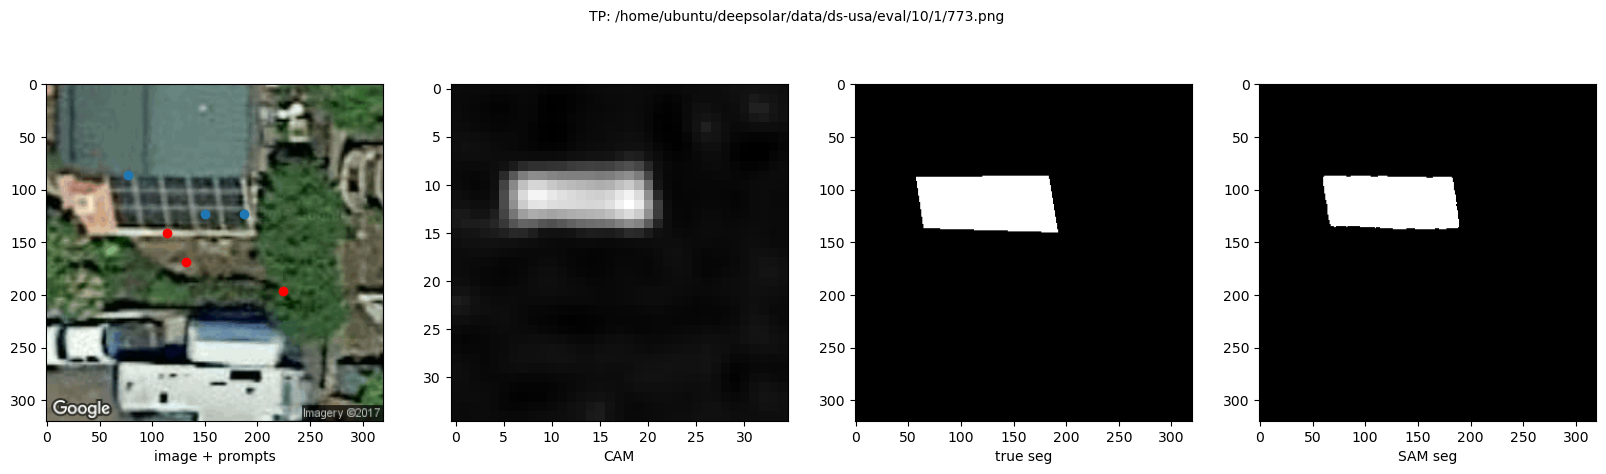

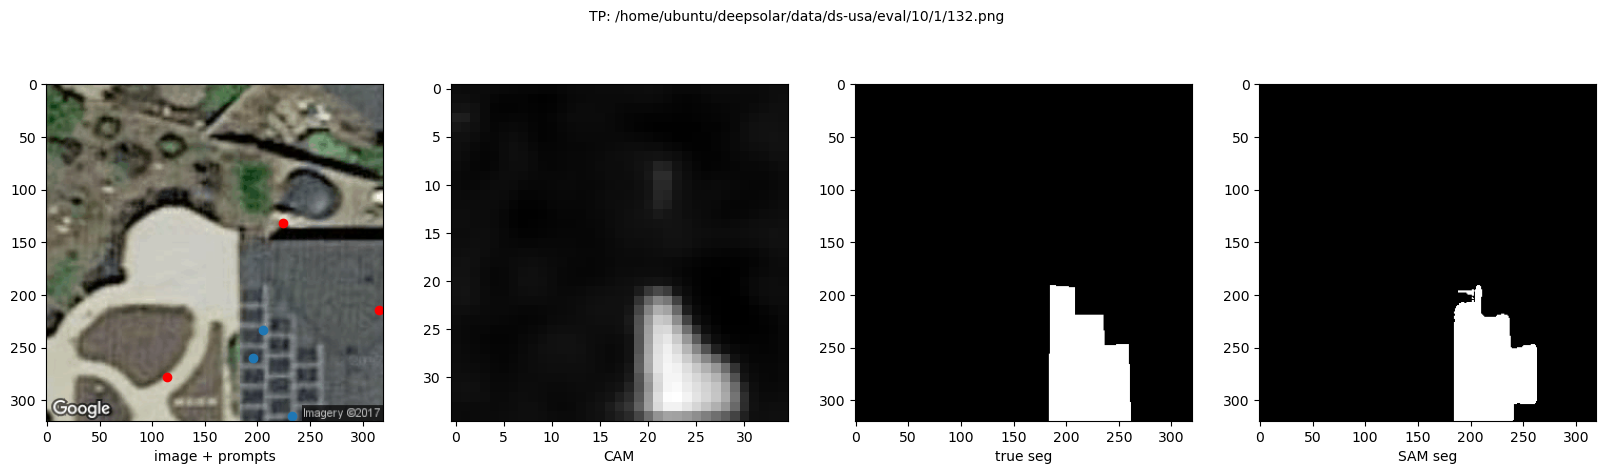

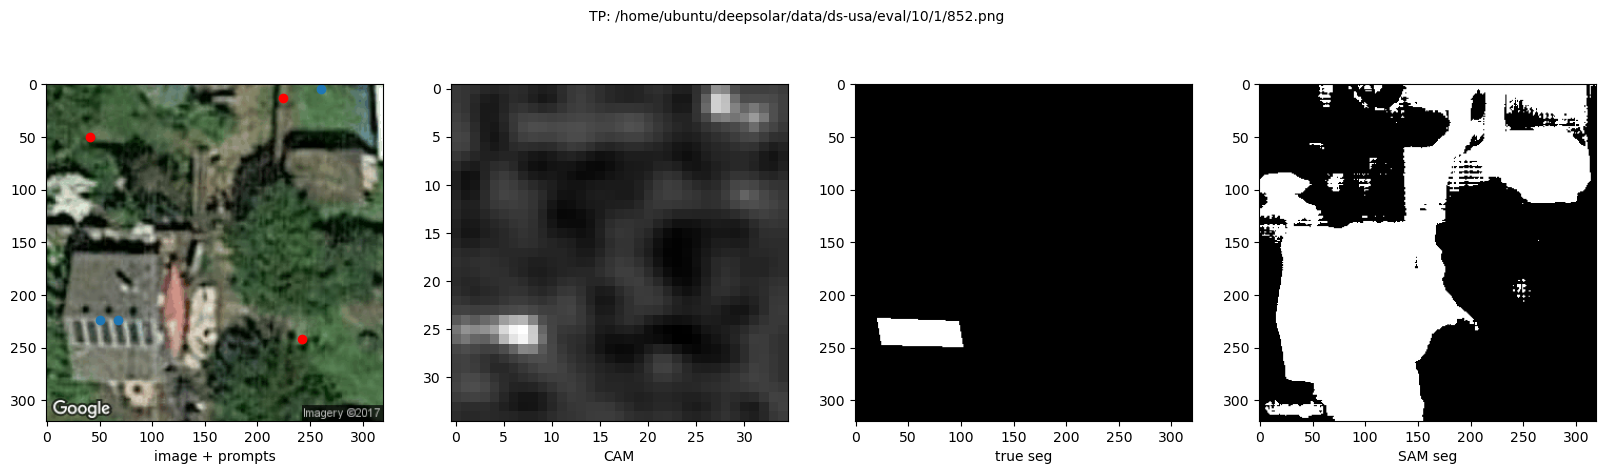

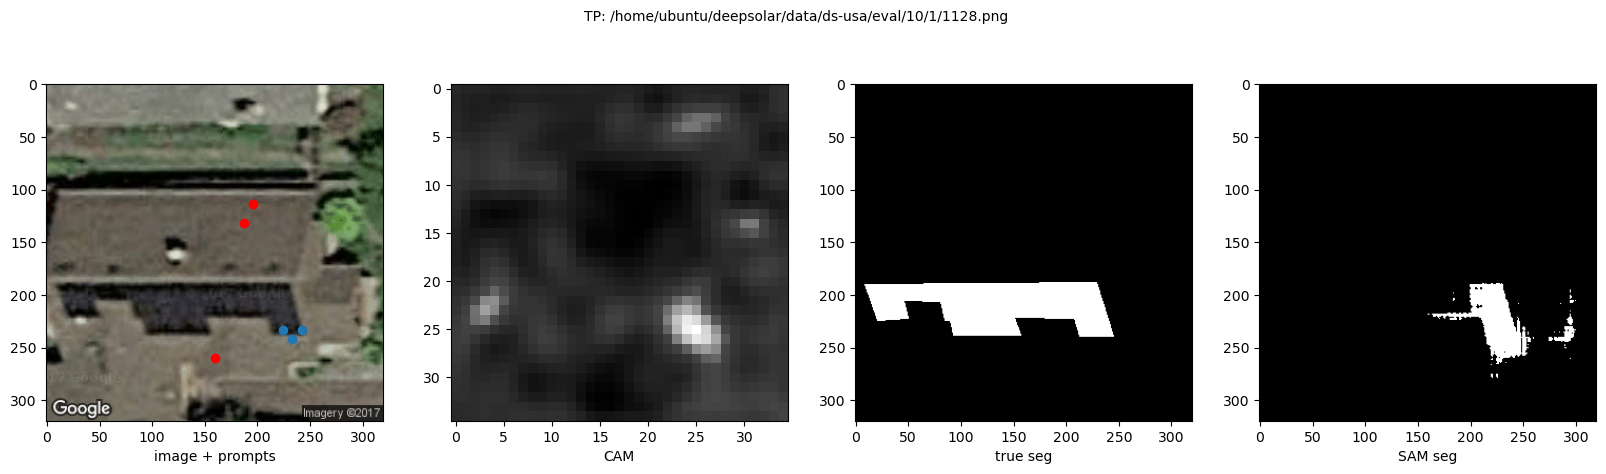

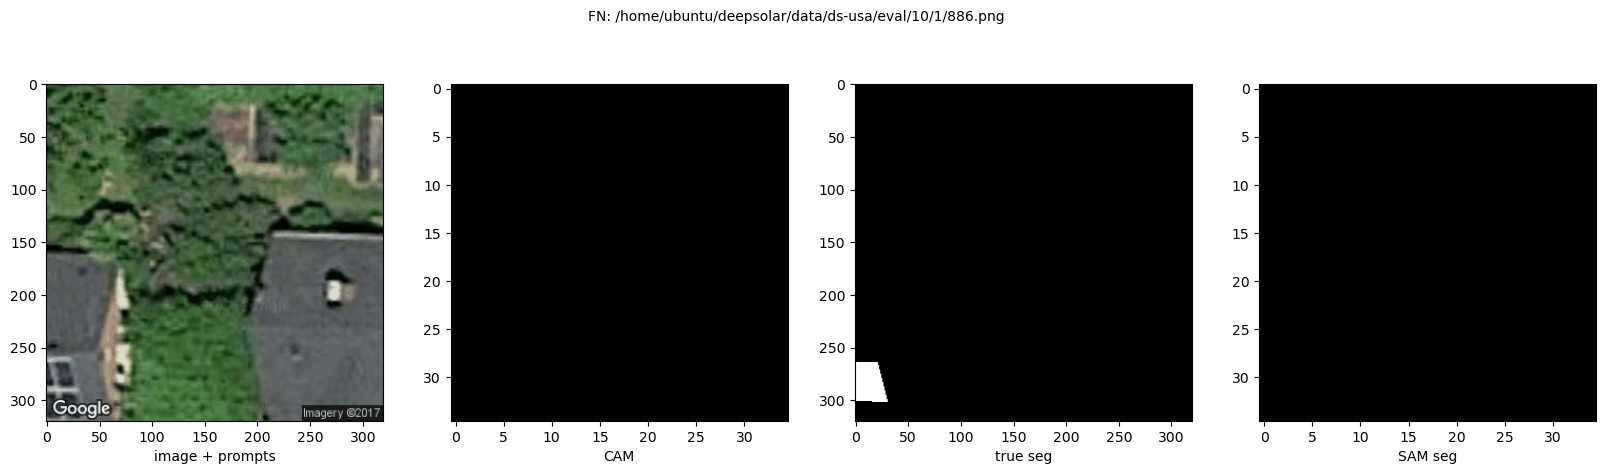

true_area: 125524.0
est_area: 185085.0
intersection: 60187.0
union: 250422.0
(fractional) area error: 0.4744989006086485
IoU: 0.2403423021938967
total count: 2981
positive count: 10


In [18]:
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

num_pos_to_evaluate=10

true_area = 0.
est_area = 0.
intersection = 0.
union = 0.

count = 0
count_pos = 0
for idx, (cam, path) in enumerate(CAM_list): 
    class_label = path.split('/')[-2]

    cam_rescaled = (cam - cam.min())/(cam.max() - cam.min() + 1e-5)

    count += 1
    if cam_rescaled.max() > 1e-3:
        # cam is nonzero.
        img = cv2.imread(path, flags=cv2.IMREAD_COLOR)

        pos_prompts, scaled_pos_prompts = extract_pos_prompts_from_cam(cam_rescaled, img, POS_THRESHOLD, N_POS_PROMPTS)
        neg_prompts, scaled_neg_prompts = extract_neg_prompts_from_cam(cam_rescaled, img, NEG_THRESHOLD, N_NEG_PROMPTS)
        if pos_prompts.shape[0] < 1:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        prepared_image = prepare_image(img, resize_transform, sam)
        x_scale = prepared_image.shape[1] / img.shape[0]
        y_scale = prepared_image.shape[2] / img.shape[1]

        combined_prompts = np.concatenate((scaled_pos_prompts, scaled_neg_prompts), axis=0)
        combined_prompts_scaled = np.copy(combined_prompts)
        combined_prompts_scaled[:,0] = (combined_prompts_scaled[:,0] * x_scale).astype(int)
        combined_prompts_scaled[:,1] = (combined_prompts_scaled[:,1] * y_scale).astype(int)
        combined_labels = np.concatenate((np.ones(N_POS_PROMPTS), np.zeros(N_NEG_PROMPTS)))

        batched_input = [{'image': prepared_image,
                          'point_coords': torch.tensor([combined_prompts_scaled]).to(sam.device),
                          'point_labels': torch.tensor([combined_labels]).to(sam.device),
                          'original_size': img.shape[:2]}]
        
        batched_output = sam(batched_input, multimask_output=False)

        mask = batched_output[0]['masks'][0]
        

        axis_titles = ['image + prompts', 'CAM', 'true seg', 'SAM seg']
        # if true positive, add to intersection and union and true area.
        if class_label == '1':
            img_path = os.path.splitext(path)
            true_seg_path = img_path[0] + '_true_seg' + img_path[1]
            true_seg = cv2.imread(true_seg_path, flags=cv2.IMREAD_GRAYSCALE)

            
            correct = np.sum(mask.cpu().numpy() & (true_seg > 1))
            intersection += correct
            union += np.sum(mask.cpu().numpy() | (true_seg > 1))

            # add to estimated area
            est_area += mask.cpu().numpy().sum()
            true_area += np.sum((true_seg > 1))
            count_pos += 1

            f, axes = plt.subplots(1, 4, figsize = (20, 5))
            axes[0].imshow(img)
            axes[0].axis('on')

            axes[1].imshow(cam_rescaled, cmap=plt.cm.gray)
            axes[1].axis('on')

            axes[2].imshow(true_seg, cmap=plt.cm.gray)
            axes[2].axis('on')

            axes[0].scatter(scaled_pos_prompts[:,0], scaled_pos_prompts[:,1])
            axes[0].scatter(scaled_neg_prompts[:,0], scaled_neg_prompts[:,1], color='r')

            axes[3].imshow(np.squeeze((mask.cpu().numpy()*255), 0).astype(int), cmap = plt.cm.gray)
            # show_mask(mask.cpu().numpy(), axes[3])
            # show_points(combined_prompts, combined_labels, axes[3], marker_size=375)
            f.suptitle('TP: ' + path, fontsize=10)
            for axis, title in zip(axes, axis_titles):
                axis.set_xlabel(title)
            plt.show()
        else:
            # else if false positive, add to union and est area.
            est_area += mask.cpu().numpy().sum()
            union += mask.cpu().numpy().sum()
            f, axes = plt.subplots(1, 4, figsize = (20, 5))
            axes[0].imshow(img)
            axes[0].axis('on')

            axes[1].imshow(cam_rescaled, cmap=plt.cm.gray)
            axes[1].axis('on')

            axes[2].imshow(np.zeros_like(cam_rescaled), cmap=plt.cm.gray)

            axes[0].scatter(scaled_pos_prompts[:,0], scaled_pos_prompts[:,1])
            axes[0].scatter(scaled_neg_prompts[:,0], scaled_neg_prompts[:,1], color='r')
            axes[3].imshow(np.squeeze((mask.cpu().numpy()*255), 0).astype(int), cmap = plt.cm.gray)
            # show_mask(mask.cpu().numpy(), axes[3])
            f.suptitle('FP: ' + path, fontsize=10)
            for axis, title in zip(axes, axis_titles):
                axis.set_xlabel(title)
            plt.show()

    elif class_label == '1':
        # false negative
        img = cv2.imread(path, flags=cv2.IMREAD_COLOR)
        img_path = os.path.splitext(path)
        true_seg_path = img_path[0] + '_true_seg' + img_path[1]
        true_seg = cv2.imread(true_seg_path, flags=cv2.IMREAD_GRAYSCALE)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        f, axes = plt.subplots(1, 4, figsize = (20, 5))
        axes[0].imshow(img)
        axes[0].axis('on')

        axes[1].imshow(cam_rescaled, cmap=plt.cm.gray)
        axes[1].axis('on')
        axes[2].imshow(true_seg, cmap=plt.cm.gray)
        axes[2].axis('on')
        axes[3].imshow(cam_rescaled, cmap=plt.cm.gray)
        axes[3].axis('on')
        f.suptitle('FN: ' + path, fontsize=10)
        for axis, title in zip(axes, axis_titles):
            axis.set_xlabel(title)
        plt.show()

        # Add to union and true area
        union += np.sum((true_seg > 1))
        true_area += np.sum((true_seg > 1))
        count_pos += 1

    # if true negative, do nothing.    

    if count_pos>= num_pos_to_evaluate:
        break

print("true_area: " + str(true_area))
print("est_area: " + str(est_area))
print("intersection: " + str(intersection))
print("union: " + str(union))
print("(fractional) area error: " + str((est_area - true_area)/ true_area))
print("IoU: " + str(intersection / union))
print("total count: " + str(count))
print("positive count: " + str(count_pos))

In [15]:
count

2982